# Script to Preprocess Joint Angle Reconstruction Data

This script must be run for each trial with `filename_joint_ang` equal to (`rep01`, ..., `rep10`).
Note: cannot find raw motion capture files to run this script, only the previously compiled data.

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. *Science Advances*. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from datetime import datetime

### Import Joint Positions and Impedance Signals
Import data frame of joint angles and apply a Savitzky-Golay smoothing filter. Import the log file from the sensor board.

In [99]:
filename_joint_ang = "random5"
joint_ang = pd.read_csv(os.path.join("MotionCapture", filename_joint_ang + ".csv"))

T_S_JOINT_ANG = 1/200
joint_ang.insert(0, 'Time', joint_ang.index*T_S_JOINT_ANG)
joint_ang_filt = joint_ang.apply(lambda x: signal.savgol_filter(x, 100, 4))
joint_ang_filt.head()

Time  LEFT_SHOULDER  LEFT_ELBOW  LEFT_WRIST
0 -4.996004e-17      12.899320   41.310011   18.817545
1  5.000000e-03      12.897322   41.311019   18.811862
2  1.000000e-02      12.895128   41.311574   18.807561
3  1.500000e-02      12.892750   41.311698   18.804575
4  2.000000e-02      12.890200   41.311414   18.802834

In [100]:
filename_z_data = [fname for fname in os.listdir('SensorBoard') if fname.startswith("Log_" + filename_joint_ang)][0]
#filename_z_data = "Log_" + filename_joint_pos + "_2022-09-15T143431"
z_data = pd.read_csv(os.path.join("SensorBoard", filename_z_data), sep='\t')

T_S_Z_DATA = 2**20/25.5e6
F_CUTOFF = 1 # Hz
b, a = signal.butter(4, F_CUTOFF*T_S_Z_DATA*2)
#z_data_filt = z_data.apply(lambda x: signal.filtfilt(b, a, x), 0)
z_data = z_data.apply(lambda x: signal.savgol_filter(x, 100, 4))
z_data['Timestamp'] = np.arange(0, (len(z_data)-0.5)*T_S_Z_DATA, T_S_Z_DATA)
cols = list(z_data.columns)
cols = [cols[0]] + cols[1::2] + cols[2::2]
z_data = z_data[cols]
z_data.head()

Timestamp          I_0          I_1          I_2          I_3          Q_0  \
0   0.000000  1368.417826  2189.913520  3927.046814  4883.102731 -1976.147971   
1   0.041121  1383.461189  2223.450401  3916.090163  4858.382780 -1955.447675   
2   0.082241  1397.432323  2254.655859  3906.273783  4836.095592 -1936.215019   
3   0.123362  1410.376604  2283.626502  3897.541295  4816.119939 -1918.390718   
4   0.164483  1422.338528  2310.457085  3889.837483  4798.337171 -1901.916566   

           Q_1          Q_2           Q_3  
0 -4666.923265 -8184.201054 -14168.239820  
1 -4657.033816 -8170.049678 -14150.739070  
2 -4648.108410 -8157.324176 -14134.461425  
3 -4640.100581 -8145.954201 -14119.359781  
4 -4632.964815 -8135.870892 -14105.387867

### Synchronization and Segmentation

In [101]:
data = z_data.copy(deep=True)
joint_ang_resampled = pd.DataFrame(data=interpolate.pchip_interpolate(joint_ang['Time'], joint_ang.iloc[:,1:], z_data['Timestamp']), columns=joint_ang.columns[1:])

data = pd.concat((joint_ang_resampled, data), axis=1)
data = data.reset_index(drop=True)
data.insert(0, 'Time',  data.pop('Timestamp'))
data.head()

Time  LEFT_SHOULDER  LEFT_ELBOW  LEFT_WRIST          I_0          I_1  \
0  0.000000      12.902861   41.317127   18.805593  1368.417826  2189.913520   
1  0.041121      12.876091   41.302871   18.814332  1383.461189  2223.450401   
2  0.082241      12.847593   41.280493   18.860878  1397.432323  2254.655859   
3  0.123362      12.817805   41.251003   18.939066  1410.376604  2283.626502   
4  0.164483      12.788404   41.217638   19.033594  1422.338528  2310.457085   

           I_2          I_3          Q_0          Q_1          Q_2  \
0  3927.046814  4883.102731 -1976.147971 -4666.923265 -8184.201054   
1  3916.090163  4858.382780 -1955.447675 -4657.033816 -8170.049678   
2  3906.273783  4836.095592 -1936.215019 -4648.108410 -8157.324176   
3  3897.541295  4816.119939 -1918.390718 -4640.100581 -8145.954201   
4  3889.837483  4798.337171 -1901.916566 -4632.964815 -8135.870892   

            Q_3  
0 -14168.239820  
1 -14150.739070  
2 -14134.461425  
3 -14119.359781  
4 -14105.387867

Segment out the incorrect trial (elbow with shoulder adducted) from Repitition 1.

In [102]:
if filename_joint_ang=='rep01':
    data.drop(data.loc[1164:2733].index, inplace=True)
    data = data.reset_index(drop=True)

Text(0.5, 1.0, 'Joint angles from motion capture')

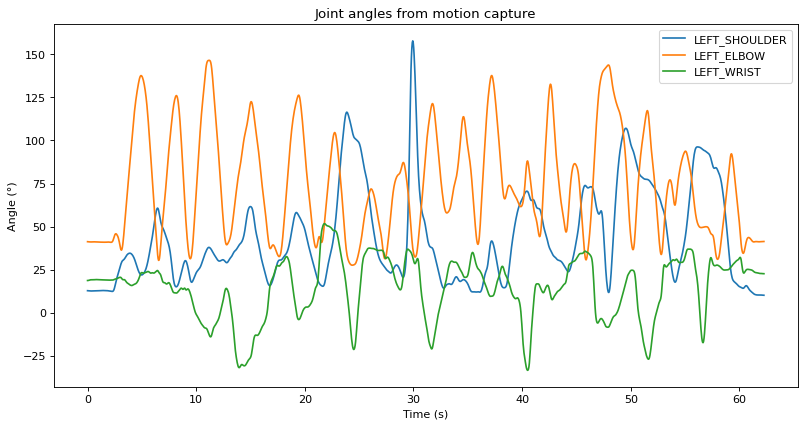

In [103]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(data[['Time']], data[['LEFT_SHOULDER', 'LEFT_ELBOW', 'LEFT_WRIST']])
plt.legend(data.columns[1:4])
plt.xlabel('Time (s)')
plt.ylabel('Angle (\u00B0)')
plt.title('Joint angles from motion capture')

In [104]:
data.to_csv(filename_joint_ang + "_data.csv")